使用如下公式生成样本数据：

$$
y = 0.05 + \sum_{i=1}^{d} 0.01 x_i + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.01^2)
$$


In [1]:
import torch
from ml_utils import *

# 训练数据小是为了过拟合
# num_inputs在这里表示特征的维度
n_train, n_test, num_inputs, batch_size = 200, 100, 200, 5

# 权重是 0.01，偏置是 0.05
true_w = torch.ones((num_inputs, 1)) * 0.01
true_b = 0.05

# 训练集数据
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)

# 测试集数据
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)


In [2]:
def squared_loss(y_hat, y):
    """"均方误差"""
    # print(((y_hat - y.reshape(y_hat.shape)) ** 2/ 2))
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats


# 配置坐标轴函数
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴属性"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


# 设置 SVG 输出
def use_svg_display():
    """使用svg格式在Jupyter中显示图像（高清）"""
    set_matplotlib_formats('svg')


# 动态绘图类
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """在一个图里动态绘制多条线"""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """添加数据点并更新图像"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        if not hasattr(x, "__len__"):
            x = [x] * n
        for i, (a, b) in enumerate(zip(x, y)):
            self.X[i].append(a)
            self.Y[i].append(b)
        self.axes[0].cla()  # 清空当前 axes
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def linreg(X,w,b):
    return X @ w + b

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            # 这里的/ batch_size其实是一个标量，让learning rate不随着batch size的变化而变化
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = Accumulator(2)  # [累计的 loss 总和, 样本总数]

    for X, y in data_iter:
        out = net(X)                          # 预测值
        y = y.reshape(out.shape)              # 调整 y 的形状与 out 匹配
        l = loss(out, y)                      # 计算损失张量（每个样本都有一个）

        metric.add(l.sum(), l.numel())        # 累加总损失 和 样本数

    return metric[0] / metric[1]              # 返回平均损失

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def train(lambd):
    w, b = init_params()
    net = lambda X: linreg(X, w, b)
    loss = squared_loss
    num_epochs, lr = 100, 0.003

    animator = Animator(
        xlabel='epochs', ylabel='loss', yscale='log',
        xlim=[5, num_epochs], legend=['train', 'test']
    )

    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                l = loss(net(X), y) + lambd * l2_penalty(w)  # 加正则项
                l.sum().backward()
            sgd([w, b], lr, batch_size)

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (
                evaluate_loss(net, train_iter, loss),
                evaluate_loss(net, test_iter, loss)
            ))

    print('w的L2范数是: ', torch.norm(w).item())


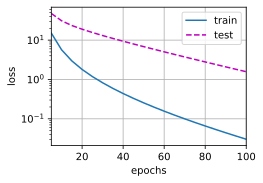

In [4]:
train(lambd=0.1)

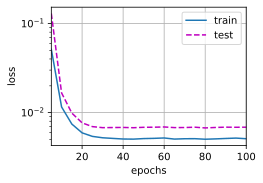

In [5]:
train(lambd=5)

In [6]:
# 正则化的简洁实现
from torch import nn
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))

    for param in net.parameters():
        param.data.normal_()

    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003

    trainer = torch.optim.SGD([
        {"params": net[0].weight, "weight_decay": wd},  # 对 weight 加正则， 唯一的区别是这里，可以对其加一个weight_decay的超参数
        {"params": net[0].bias}                         # 对 bias 不加正则
    ], lr=lr)

    animator = Animator(
        xlabel='epochs', ylabel='loss', yscale='log',
        xlim=[5, num_epochs], legend=['train', 'test']
    )

    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
                l.backward()
                trainer.step()

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (
                evaluate_loss(net, train_iter, loss),
                evaluate_loss(net, test_iter, loss)
            ))

    print('w的L2范数是:', torch.norm(net[0].weight).item())



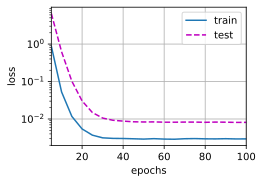

In [7]:
train_concise(2)